# Step One: 
## Engineered Features to Predict Finishing Position:

### Feature Engineering:

Creating a number of **Engineered Features** to use in our analysis:

**Relative Performance in each race:**
- > 1. Avg Speed 
- > 2. Avg Speed & Avg Last 100m Speed
- Improving Avg Speed (current vs shift(periods=1)
- > Average Last 100m speed 
- > Best Last 100m speed 
- Best Distance & Surface speed figure relative… (continuous)

- Horse Optimum weight… (groupby horse; weight & lbw)
- > Handicap Weight 
- > Barrier % 
- > Odds 'Public_prob' 
- > Jockey 'jock_win %
- > Trainer 'trainer_win %
- > Jockey/Trainer combo win %

**Engineered Features (Absolute data):**
- Change of Equipment (nominal)
- Change in Horse Weight (continuous) 
- Other Numerical Features (Absolute data):
- Days since Last Race (continuous) 

**Other NLP Features:**
- Trouble in past run (text - ordinal)
- Track conditions (text - ordinal)

**Target:**
- Lengths Behind Winner (LBW) (continuous)

**Other:**
- > jockey's which save ground

**All numbers have to be converted to relative in each race for comparison to LBW**

Feature importance:
https://mlr.mlr-org.com/articles/tutorial/feature_selection.html

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.dummy import DummyRegressor

import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

In [2]:
# Import data: 
df = pd.read_csv('./datasets/stc_data_cleaned.csv', parse_dates=['date'], dayfirst=True)
df = df.drop(['Unnamed: 0'], axis=1)

#df.head()

# Public Prob vs LBW (benchmark)

In [3]:
X = df[['public_prob']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -7.794604047766618
Coefficients: 
 [0.17229501]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1119.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          7.85e-233
Time:                        19:00:15   Log-Likelihood:                -32587.
No. Observations:               10233   AIC:                         6.518e+04
Df Residuals:                   10231   BIC:                         6.519e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [4]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [5]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.8


In [6]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.099


(-6.5, 0)

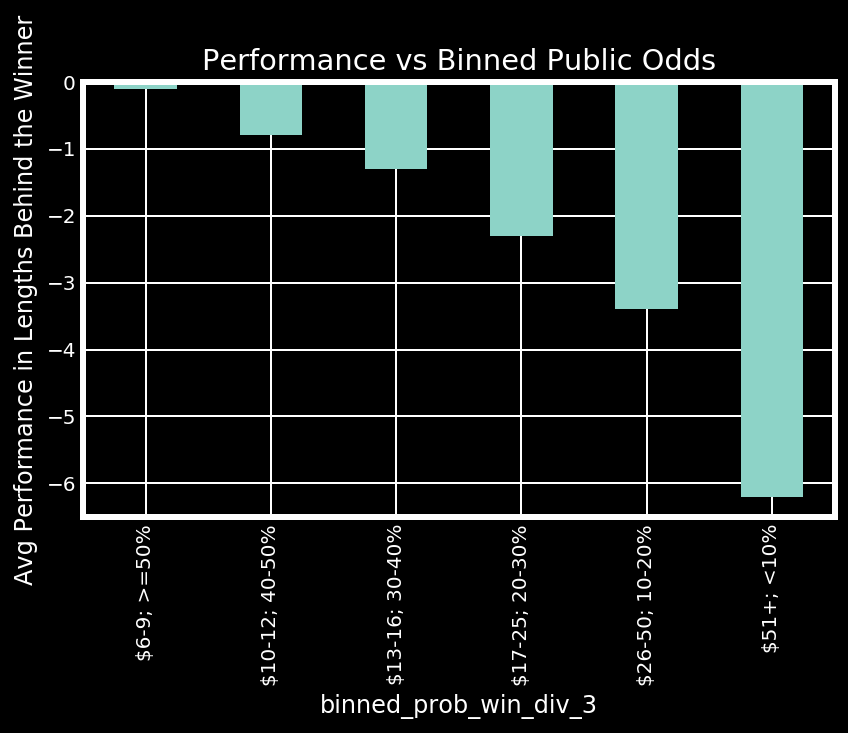

In [7]:
# histogram on 'binned_public_prob' & 'binned_lbw':
plt.style.use('dark_background')
odds_bin_ranges = [0, 10.5, 12.5, 16.5, 25.5, 50.5, 2000]
odds_bin_names = ['$6-9; >=50%', '$10-12; 40-50%', '$13-16; 30-40%', '$17-25; 20-30%', '$26-50; 10-20%', '$51+; <10%']

df['binned_prob_win_div_3'] = pd.cut((df['win_div_3']), bins=odds_bin_ranges,labels=odds_bin_names)

public_prob_perf = df[['lbw', 'binned_prob_win_div_3']].groupby('binned_prob_win_div_3').agg('median')

plt.style.use('dark_background')
plt.title('Performance vs Binned Public Odds')
plt.xlabel('Odds (<<Favorites---Longshots>>>)')
plt.ylabel('Avg Performance in Lengths Behind the Winner')

plt.style.use('dark_background')
public_prob_perf['lbw'].plot.bar()

#plt.xlim(0, -20)  
plt.ylim(-6.5, 0) 

# Engineered Feature 1: Speed
#### Feature 1 calculates each horse’s past speed (median; mean; max; min, etc) versus standard, converts this into lengths versus standard, then ranks this against its race peers for the current race.  

In [8]:
# Create 'standard_speed' (avg_speed on surface & distance) merge back to df:
temp = df.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean']) 

# merge standard_speed_1 back into df & rename(columns={'median': 'standard_speed_1'}, inplace=True)
df = pd.merge(df, temp, on='indexing_surf_dist')
df.rename(columns={'mean': 'standard_speed_1'}, inplace=True)

In [9]:
temp

,mean
indexing_surf_dist,
100.0,60.501393
110.0,60.179466
120.0,59.789870
160.0,57.421751
170.0,57.110159
180.0,56.857143
1200.0,61.372541
1400.0,60.685323
1600.0,60.183138


In [10]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,binned_win_div_3,public_prob,total_count,win_count,total_wager,return_wager,loss_rebate,profit_loss,binned_prob_win_div_3,standard_speed_1
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,$21+; Prob. <25%,13.513514,1,1,5,37,0.0,32.0,$26-50; 10-20%,61.372541
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,$6-20; Prob. >=25%,26.315789,1,0,5,0,0.5,-4.5,$17-25; 20-30%,61.372541
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,$6-20; Prob. >=25%,45.454545,1,0,5,0,0.5,-4.5,$10-12; 40-50%,61.372541
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,$21+; Prob. <25%,3.623188,1,0,5,0,0.5,-4.5,$51+; <10%,61.372541
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,$21+; Prob. <25%,3.401361,1,0,5,0,0.5,-4.5,$51+; <10%,61.372541


In [11]:
# Horse speed vs standard in lengths 
df = df.assign(lengths_vs_standard_1 = ((df['avg_km_hr_2'] - df['standard_speed_1'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = df['lengths_vs_standard_1'].groupby(df['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
df = pd.merge(df, temp, on='horse_name')
df.rename(columns={'50%': 'horse_median_vs_standard'}, inplace=True)   #f1

# used for other engineered features:
df.rename(columns={'mean': 'horse_mean_vs_standard'}, inplace=True)    #f1a
df.rename(columns={'75%': 'horse_top_qtr_vs_standard'}, inplace=True)  #f1b
df.rename(columns={'max': 'horse_max_vs_standard'}, inplace=True)      #f1c
df.rename(columns={'min': 'horse_min_vs_standard'}, inplace=True)      #f1d
df.rename(columns={'25%': 'horse_bot_qtr_vs_standard'}, inplace=True)  #f1e

df.rename(columns={'std': 'horse_stdev'}, inplace=True)                #f1f
df.rename(columns={'count': 'horse_race_count'}, inplace=True)         #f1g

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

In [12]:
temp

,count,mean,std,min,25%,50%,75%,max
horse_name,,,,,,,,
AABIR,4.0,4.104114,4.589265,-1.907784,2.665743,4.540252,5.978623,9.243735
ABEBE,4.0,-2.010792,3.492189,-4.839617,-4.271380,-3.060792,-0.800204,2.918033
ABLE PINS,1.0,-18.209748,NaN,-18.209748,-18.209748,-18.209748,-18.209748,-18.209748
ABSOLUTE MIRACLE,18.0,3.247363,3.926757,-8.281967,2.206562,2.947477,5.527738,8.947743
ABSOLVIDO,15.0,3.567235,3.546340,-2.952257,1.197477,3.602738,6.036823,11.270907
ACCELERANDO,3.0,-2.870943,1.030771,-4.007784,-3.307784,-2.607784,-2.302523,-1.997262
ACCUMULATION,14.0,0.163518,3.660271,-4.797262,-2.510791,-0.218438,3.045907,6.370907
ACE HARBOUR,10.0,1.101827,3.483691,-4.797262,-0.787270,1.027718,4.307692,5.528889
ACE'S WILD,2.0,-1.207784,2.969848,-3.307784,-2.257784,-1.207784,-0.157784,0.892216


In [13]:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_median_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_1 = ((df['horse_median_vs_standard'] - df['temp_1'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_1', axis=1)

In [14]:
df.shape

(10233, 49)

In [15]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,lengths_vs_standard_1,horse_race_count,horse_mean_vs_standard,horse_stdev,horse_min_vs_standard,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,2.292216,10.0,-3.108614,5.308894,-13.929093,-5.299472,-3.392679,-0.031265,5.043735,-0.715916
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-0.507784,11.0,-4.883550,5.818571,-18.056265,-6.583006,-4.056265,-0.330020,1.470907,-1.379502
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,0.192216,8.0,-2.867889,2.662904,-7.629093,-3.930220,-2.676763,-0.621135,0.192216,0.000000
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,0.192216,2.0,-4.402523,6.497942,-8.997262,-6.699892,-4.402523,-2.105153,0.192216,-1.725759
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-3.307784,8.0,-6.568869,4.062042,-12.052257,-9.499892,-6.690675,-3.043902,-1.552257,-4.013912


In [16]:
X = df[['feature_1']] 
y = df['lbw']
 

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.344187226344684
Coefficients: 
 [0.84795994]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     2832.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:18   Log-Likelihood:                -31868.
No. Observations:               10233   AIC:                         6.374e+04
Df Residuals:                   10231   BIC:                         6.375e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [18]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.4


In [19]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.217


### Engineered Feature 1a: Mean Speed

In [20]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_mean_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_1a = ((df['horse_mean_vs_standard'] - df['temp_1a'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_1a', axis=1)

In [21]:
df.shape

(10233, 50)

In [22]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_race_count,horse_mean_vs_standard,horse_stdev,horse_min_vs_standard,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1,feature_1a
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,10.0,-3.108614,5.308894,-13.929093,-5.299472,-3.392679,-0.031265,5.043735,-0.715916,-0.240724
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,11.0,-4.883550,5.818571,-18.056265,-6.583006,-4.056265,-0.330020,1.470907,-1.379502,-2.015661
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,8.0,-2.867889,2.662904,-7.629093,-3.930220,-2.676763,-0.621135,0.192216,0.000000,0.000000
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,2.0,-4.402523,6.497942,-8.997262,-6.699892,-4.402523,-2.105153,0.192216,-1.725759,-1.534634
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,8.0,-6.568869,4.062042,-12.052257,-9.499892,-6.690675,-3.043902,-1.552257,-4.013912,-3.700980


In [23]:
X = df[['feature_1a']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.133292630293091
Coefficients: 
 [0.88227928]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     3554.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:18   Log-Likelihood:                -31593.
No. Observations:               10233   AIC:                         6.319e+04
Df Residuals:                   10231   BIC:                         6.320e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [25]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.3


In [26]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.258


### Engineered Feature 1b: Top Quartile Speed

In [27]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_top_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_1b = ((df['horse_top_qtr_vs_standard'] - df['temp_1b'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_1b', axis=1)

In [28]:
df.shape

(10233, 51)

In [29]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_mean_vs_standard,horse_stdev,horse_min_vs_standard,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1,feature_1a,feature_1b
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,-3.108614,5.308894,-13.929093,-5.299472,-3.392679,-0.031265,5.043735,-0.715916,-0.240724,0.000000
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-4.883550,5.818571,-18.056265,-6.583006,-4.056265,-0.330020,1.470907,-1.379502,-2.015661,-0.298755
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,-2.867889,2.662904,-7.629093,-3.930220,-2.676763,-0.621135,0.192216,0.000000,0.000000,-0.589870
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,-4.402523,6.497942,-8.997262,-6.699892,-4.402523,-2.105153,0.192216,-1.725759,-1.534634,-2.073888
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-6.568869,4.062042,-12.052257,-9.499892,-6.690675,-3.043902,-1.552257,-4.013912,-3.700980,-3.012637


In [30]:
X = df[['feature_1b']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.46773464887447
Coefficients: 
 [0.81310262]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     2587.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:18   Log-Likelihood:                -31965.
No. Observations:               10233   AIC:                         6.393e+04
Df Residuals:                   10231   BIC:                         6.395e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [31]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [32]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.5


In [33]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.202


### Engineered Feature 1c: Max Speed (horse_max_vs_standard)

In [34]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_max_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_1c = ((df['horse_max_vs_standard'] - df['temp_1c'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_1c', axis=1)

In [35]:
df.shape

(10233, 52)

In [36]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_stdev,horse_min_vs_standard,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1,feature_1a,feature_1b,feature_1c
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,5.308894,-13.929093,-5.299472,-3.392679,-0.031265,5.043735,-0.715916,-0.240724,0.000000,0.000000
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,5.818571,-18.056265,-6.583006,-4.056265,-0.330020,1.470907,-1.379502,-2.015661,-0.298755,-3.572828
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,2.662904,-7.629093,-3.930220,-2.676763,-0.621135,0.192216,0.000000,0.000000,-0.589870,-4.851519
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,6.497942,-8.997262,-6.699892,-4.402523,-2.105153,0.192216,-1.725759,-1.534634,-2.073888,-4.851519
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,4.062042,-12.052257,-9.499892,-6.690675,-3.043902,-1.552257,-4.013912,-3.700980,-3.012637,-6.595992


In [37]:
X = df[['feature_1c']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.7571647184829398
Coefficients: 
 [0.52347283]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     1606.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:18   Log-Likelihood:                -32372.
No. Observations:               10233   AIC:                         6.475e+04
Df Residuals:                   10231   BIC:                         6.476e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [38]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [39]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.7


In [40]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.136


### Engineered Feature 1d: Min Speed (horse_min_vs_standard)

In [41]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_min_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1d'}, inplace=True)

# new column 
df = df.assign(feature_1d = ((df['horse_min_vs_standard'] - df['temp_1d'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_1d', axis=1)

In [42]:
df.shape

(10233, 53)

In [43]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_min_vs_standard,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1,feature_1a,feature_1b,feature_1c,feature_1d
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,-13.929093,-5.299472,-3.392679,-0.031265,5.043735,-0.715916,-0.240724,0.000000,0.000000,-6.300000
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-18.056265,-6.583006,-4.056265,-0.330020,1.470907,-1.379502,-2.015661,-0.298755,-3.572828,-10.427172
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,-7.629093,-3.930220,-2.676763,-0.621135,0.192216,0.000000,0.000000,-0.589870,-4.851519,0.000000
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,-8.997262,-6.699892,-4.402523,-2.105153,0.192216,-1.725759,-1.534634,-2.073888,-4.851519,-1.368169
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-12.052257,-9.499892,-6.690675,-3.043902,-1.552257,-4.013912,-3.700980,-3.012637,-6.595992,-4.423164


In [44]:
X = df[['feature_1d']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -3.7778966341313827
Coefficients: 
 [0.28811219]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1474.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          1.88e-301
Time:                        19:00:18   Log-Likelihood:                -32430.
No. Observations:               10233   AIC:                         6.486e+04
Df Residuals:                   10231   BIC:                         6.488e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [45]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [46]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.8


In [47]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.126


### Engineered Feature 1e:  Bottom Quartile Speed (horse_bot_qtr_vs_standard)

In [48]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1e'}, inplace=True)

# new column in df 
df = df.assign(feature_1e = ((df['horse_bot_qtr_vs_standard'] - df['temp_1e'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_1e', axis=1)

In [49]:
df.shape

(10233, 54)

In [50]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1,feature_1a,feature_1b,feature_1c,feature_1d,feature_1e
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,-5.299472,-3.392679,-0.031265,5.043735,-0.715916,-0.240724,0.000000,0.000000,-6.300000,-1.369253
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-6.583006,-4.056265,-0.330020,1.470907,-1.379502,-2.015661,-0.298755,-3.572828,-10.427172,-2.652787
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,-3.930220,-2.676763,-0.621135,0.192216,0.000000,0.000000,-0.589870,-4.851519,0.000000,0.000000
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,-6.699892,-4.402523,-2.105153,0.192216,-1.725759,-1.534634,-2.073888,-4.851519,-1.368169,-2.769673
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-9.499892,-6.690675,-3.043902,-1.552257,-4.013912,-3.700980,-3.012637,-6.595992,-4.423164,-5.569673


In [51]:
X = df[['feature_1e']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.407363361226987
Coefficients: 
 [0.76010427]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     2967.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:18   Log-Likelihood:                -31815.
No. Observations:               10233   AIC:                         6.363e+04
Df Residuals:                   10231   BIC:                         6.365e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [52]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [53]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.4


In [54]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.225


# Engineered Feature 3: Speed & Finishing (F1 + F2)/2
#### Feature 3 calculates each horse’s speed & finishing (median; mean; max; min, etc) versus standard, converts this into lengths versus standard, then ranks this against its race peers for the current race.  

In [55]:
# Create 'standard_speed' (avg_speed & l100m) on surface & distance) merge back to df:
temp = ((df.groupby(['indexing_surf_dist']).avg_km_hr_2.agg(['mean'])) 
        + (df.groupby(['indexing_surf_dist']).l100m_km_hr_2.agg(['mean'])))/2

# merge standard_speed_2 back into df & rename(columns={'median': 'standard_speed_2'}, inplace=True)
df = pd.merge(df, temp, on='indexing_surf_dist')
df.rename(columns={'mean': 'standard_speed_3'}, inplace=True)

In [56]:
temp

,mean
indexing_surf_dist,
100.0,58.967145
110.0,58.001778
120.0,57.588251
160.0,55.713338
170.0,55.280794
180.0,55.228022
1200.0,60.202054
1400.0,59.308269
1600.0,58.773302


In [57]:
# Horse speed & l100m vs standard in lengths 
df = df.assign(lengths_vs_standard_3 = (((((df['l100m_km_hr_2'])+(df['avg_km_hr_2']))/2) 
                                         - df['standard_speed_3'] ) * 7)) # 7 lengths/kmph

# Groupby Horse on stats:
temp = df['lengths_vs_standard_3'].groupby(df['horse_name']).describe(include=all)

# merge desc back into df groupby horse (this is the horses detailed speed fig)
df = pd.merge(df, temp, on='horse_name')
df.rename(columns={'50%': 'horse_median_vs_standard_3'}, inplace=True)

# used for other engineered features:
df.rename(columns={'mean': 'horse_mean_vs_standard_3'}, inplace=True)    #f2a
df.rename(columns={'75%': 'horse_top_qtr_vs_standard_3'}, inplace=True)  #f2b
df.rename(columns={'max': 'horse_max_vs_standard_3'}, inplace=True)      #f2c
df.rename(columns={'min': 'horse_min_vs_standard_3'}, inplace=True)      #f2d
df.rename(columns={'25%': 'horse_bot_qtr_vs_standard_3'}, inplace=True)  #f2e

df.rename(columns={'std': 'horse_stdev_3'}, inplace=True)                #f2f
df.rename(columns={'count': 'horse_race_count_3'}, inplace=True)         #f2g

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

In [58]:
temp

,count,mean,std,min,25%,50%,75%,max
horse_name,,,,,,,,
AABIR,4.0,3.345784,3.975871,-0.714378,1.306392,2.679983,4.719375,8.737551
ABEBE,4.0,-9.084273,9.923561,-14.505431,-14.242931,-13.809273,-8.650615,5.786885
ABLE PINS,1.0,-55.070017,NaN,-55.070017,-55.070017,-55.070017,-55.070017,-55.070017
ABSOLUTE MIRACLE,18.0,2.444856,8.942427,-22.563115,0.615807,3.782802,8.840505,13.486885
ABSOLVIDO,15.0,12.850637,7.746565,2.636885,7.642114,11.142114,17.533933,31.092114
ACCELERANDO,3.0,-16.362214,12.036855,-23.464378,-23.311132,-23.157886,-12.811132,-2.464378
ACCUMULATION,14.0,3.975167,10.409873,-11.713115,-1.597854,3.249374,7.169744,24.092114
ACE HARBOUR,10.0,4.434031,6.929056,-5.657886,1.085085,3.880240,7.263018,16.584444
ACE'S WILD,2.0,-1.589378,2.227386,-3.164378,-2.376878,-1.589378,-0.801878,-0.014378


In [59]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,standard_speed_3,lengths_vs_standard_3,horse_race_count_3,horse_mean_vs_standard_3,horse_stdev_3,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,60.202054,6.635622,10.0,-4.544991,9.649337,-27.917756,-6.201276,-4.266233,2.175051,6.635622
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,60.202054,-2.814378,11.0,-10.172322,8.511953,-20.070017,-17.290103,-12.262449,-4.913414,5.237551
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,60.202054,3.485622,8.0,1.843281,7.086916,-12.867756,-1.247854,4.058933,5.728473,9.042114
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,60.202054,4.535622,2.0,-6.686132,15.869956,-17.907886,-12.297009,-6.686132,-1.075255,4.535622
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,60.202054,0.685622,8.0,-13.915983,17.795588,-43.143365,-25.186119,-10.680561,1.199745,5.506635


In [60]:
# Median speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_median_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_3'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_3 = ((df['horse_median_vs_standard_3'] - df['temp_3'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_3', axis=1)

In [61]:
df.shape

(10233, 65)

In [62]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,lengths_vs_standard_3,horse_race_count_3,horse_mean_vs_standard_3,horse_stdev_3,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,6.635622,10.0,-4.544991,9.649337,-27.917756,-6.201276,-4.266233,2.175051,6.635622,-9.248477
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-2.814378,11.0,-10.172322,8.511953,-20.070017,-17.290103,-12.262449,-4.913414,5.237551,-17.244693
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,3.485622,8.0,1.843281,7.086916,-12.867756,-1.247854,4.058933,5.728473,9.042114,-0.923311
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,4.535622,2.0,-6.686132,15.869956,-17.907886,-12.297009,-6.686132,-1.075255,4.535622,-11.668376
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,0.685622,8.0,-13.915983,17.795588,-43.143365,-25.186119,-10.680561,1.199745,5.506635,-15.662805


In [63]:
X = df[['feature_3']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.8438316895519624
Coefficients: 
 [0.36161555]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     2065.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:21   Log-Likelihood:                -32178.
No. Observations:               10233   AIC:                         6.436e+04
Df Residuals:                   10231   BIC:                         6.437e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [64]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [65]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.6


In [66]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.168


### Engineered Feature 3a: Mean Speed

In [67]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_mean_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_3a'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_3a = ((df['horse_mean_vs_standard_3'] - df['temp_3a'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_3a', axis=1)

In [68]:
df.shape

(10233, 66)

In [69]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_race_count_3,horse_mean_vs_standard_3,horse_stdev_3,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3,feature_3a
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,10.0,-4.544991,9.649337,-27.917756,-6.201276,-4.266233,2.175051,6.635622,-9.248477,-7.688345
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,11.0,-10.172322,8.511953,-20.070017,-17.290103,-12.262449,-4.913414,5.237551,-17.244693,-13.315675
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,8.0,1.843281,7.086916,-12.867756,-1.247854,4.058933,5.728473,9.042114,-0.923311,-1.300073
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,2.0,-6.686132,15.869956,-17.907886,-12.297009,-6.686132,-1.075255,4.535622,-11.668376,-9.829486
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,8.0,-13.915983,17.795588,-43.143365,-25.186119,-10.680561,1.199745,5.506635,-15.662805,-17.059336


In [70]:
X = df[['feature_3a']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.564896274911566
Coefficients: 
 [0.37378979]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     2563.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:21   Log-Likelihood:                -31974.
No. Observations:               10233   AIC:                         6.395e+04
Df Residuals:                   10231   BIC:                         6.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [71]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [72]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.5


In [73]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.200


## Engineered Feature 3b: Top Quartile Speed

In [74]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_top_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_3b'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_3b = ((df['horse_top_qtr_vs_standard_3'] - df['temp_3b'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_3b', axis=1)

In [75]:
df.shape

(10233, 67)

In [76]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_mean_vs_standard_3,horse_stdev_3,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3,feature_3a,feature_3b
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,-4.544991,9.649337,-27.917756,-6.201276,-4.266233,2.175051,6.635622,-9.248477,-7.688345,-4.557193
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-10.172322,8.511953,-20.070017,-17.290103,-12.262449,-4.913414,5.237551,-17.244693,-13.315675,-11.645658
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,1.843281,7.086916,-12.867756,-1.247854,4.058933,5.728473,9.042114,-0.923311,-1.300073,-1.003771
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,-6.686132,15.869956,-17.907886,-12.297009,-6.686132,-1.075255,4.535622,-11.668376,-9.829486,-7.807499
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-13.915983,17.795588,-43.143365,-25.186119,-10.680561,1.199745,5.506635,-15.662805,-17.059336,-5.532499


In [77]:
X = df[['feature_3b']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -3.1221195390203875
Coefficients: 
 [0.34804112]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1668.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:21   Log-Likelihood:                -32346.
No. Observations:               10233   AIC:                         6.470e+04
Df Residuals:                   10231   BIC:                         6.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [78]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [79]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.7


In [80]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.140


### Engineered Feature 3c: Max Speed (horse_max_vs_standard)

In [81]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_max_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_3c'}, inplace=True)

# new column in df 'f1_horse_lengths_vs_max_in_race' calc
df = df.assign(feature_3c = ((df['horse_max_vs_standard_3'] - df['temp_3c'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_3c', axis=1)

In [82]:
df.shape

(10233, 68)

In [83]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_stdev_3,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3,feature_3a,feature_3b,feature_3c
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,9.649337,-27.917756,-6.201276,-4.266233,2.175051,6.635622,-9.248477,-7.688345,-4.557193,-14.244361
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,8.511953,-20.070017,-17.290103,-12.262449,-4.913414,5.237551,-17.244693,-13.315675,-11.645658,-15.642432
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,7.086916,-12.867756,-1.247854,4.058933,5.728473,9.042114,-0.923311,-1.300073,-1.003771,-11.837869
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,15.869956,-17.907886,-12.297009,-6.686132,-1.075255,4.535622,-11.668376,-9.829486,-7.807499,-16.344361
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,17.795588,-43.143365,-25.186119,-10.680561,1.199745,5.506635,-15.662805,-17.059336,-5.532499,-15.373348


In [84]:
X = df[['feature_3c']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -4.353469678009928
Coefficients: 
 [0.09017966]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     364.1
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           8.88e-80
Time:                        19:00:21   Log-Likelihood:                -32939.
No. Observations:               10233   AIC:                         6.588e+04
Df Residuals:                   10231   BIC:                         6.590e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [85]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [86]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 6.0


In [87]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.034


### Engineered Feature 3d: Min Speed (horse_min_vs_standard)

In [88]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_min_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_3d'}, inplace=True)

# new column 
df = df.assign(feature_3d = ((df['horse_min_vs_standard_3'] - df['temp_3d'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_3d', axis=1)

In [89]:
df.shape

(10233, 69)

In [90]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3,feature_3a,feature_3b,feature_3c,feature_3d
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,-27.917756,-6.201276,-4.266233,2.175051,6.635622,-9.248477,-7.688345,-4.557193,-14.244361,-21.953378
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-20.070017,-17.290103,-12.262449,-4.913414,5.237551,-17.244693,-13.315675,-11.645658,-15.642432,-14.105639
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,-12.867756,-1.247854,4.058933,5.728473,9.042114,-0.923311,-1.300073,-1.003771,-11.837869,-6.903378
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,-17.907886,-12.297009,-6.686132,-1.075255,4.535622,-11.668376,-9.829486,-7.807499,-16.344361,-11.943508
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-43.143365,-25.186119,-10.680561,1.199745,5.506635,-15.662805,-17.059336,-5.532499,-15.373348,-37.178987


In [91]:
X = df[['feature_3d']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -3.738862079351853
Coefficients: 
 [0.12347246]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     1341.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          5.43e-276
Time:                        19:00:21   Log-Likelihood:                -32488.
No. Observations:               10233   AIC:                         6.498e+04
Df Residuals:                   10231   BIC:                         6.499e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [92]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [93]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.8


In [94]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.116


### Engineered Feature 3e:  Bottom Quartile Speed (horse_bot_qtr_vs_standard)

In [95]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_bot_qtr_vs_standard_3.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_3e'}, inplace=True)

# new column in df 
df = df.assign(feature_3e = ((df['horse_bot_qtr_vs_standard_3'] - df['temp_3e'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.drop('temp_3e', axis=1)

In [96]:
df.shape

(10233, 70)

In [97]:
df.head()

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3,feature_3a,feature_3b,feature_3c,feature_3d,feature_3e
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,-6.201276,-4.266233,2.175051,6.635622,-9.248477,-7.688345,-4.557193,-14.244361,-21.953378,-7.460209
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,-17.290103,-12.262449,-4.913414,5.237551,-17.244693,-13.315675,-11.645658,-15.642432,-14.105639,-18.549036
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,-1.247854,4.058933,5.728473,9.042114,-0.923311,-1.300073,-1.003771,-11.837869,-6.903378,-2.506786
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,-12.297009,-6.686132,-1.075255,4.535622,-11.668376,-9.829486,-7.807499,-16.344361,-11.943508,-13.555942
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,-25.186119,-10.680561,1.199745,5.506635,-15.662805,-17.059336,-5.532499,-15.373348,-37.178987,-26.445051


In [98]:
X = df[['feature_3e']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -2.868567993436305
Coefficients: 
 [0.31893491]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     2313.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:21   Log-Likelihood:                -32075.
No. Observations:               10233   AIC:                         6.415e+04
Df Residuals:                   10231   BIC:                         6.417e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [99]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [100]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.6


In [101]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.184


### Engineered Feature 5: Jockey Win %
#### F5 is a calculation of each horse’s expected win probability in a race based on a jockey's win %

In [102]:
# 'jock_pct':
jock_win = df[['jockey', 'win_count', 'total_count']].groupby('jockey').agg('sum')
jock_win = jock_win.assign(jock_pct = (jock_win['win_count'] / jock_win['total_count']) * 100)
jock_win = jock_win.drop(['win_count', 'total_count'], axis=1)
df = pd.merge(df, jock_win, on='jockey')

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

# Groupby date & race, then sum jockey % (to be used in calc of each jockey's race % relative):
jockey_pct_race = df.groupby(['indexing_date_race']).jock_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, jockey_pct_race, on='indexing_date_race')
df.rename(columns={'max': 'max_jock_pct_race'}, inplace=True)

# new column in df 'f5_jock_pct_race' calc (sort of expressed as lbw)
df = df.assign(jock_pct_race_f5 = 
               ((df['jock_pct'] - df['max_jock_pct_race'] ) )) 

In [103]:
df.head()
#df.loc[(df['jockey'] == 'R WOODWORTH') ]

,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,...,horse_max_vs_standard_3,feature_3,feature_3a,feature_3b,feature_3c,feature_3d,feature_3e,jock_pct,max_jock_pct_race,jock_pct_race_f5
0,2018-06-01,1,C5,1200,T,ROCKET FIGHTER,33,551,52.0,52.0,...,6.635622,-9.248477,-7.688345,-4.557193,-14.244361,-21.953378,-7.460209,15.384615,17.735043,-2.350427
1,2018-06-01,1,C5,1200,T,DOMINY,43,490,57.0,57.0,...,5.237551,-17.244693,-13.315675,-11.645658,-15.642432,-14.105639,-18.549036,11.875000,17.735043,-5.860043
2,2018-06-01,1,C5,1200,T,GREATBALLS OF FIRE,42,515,56.5,56.5,...,9.042114,-0.923311,-1.300073,-1.003771,-11.837869,-6.903378,-2.506786,17.735043,17.735043,0.000000
3,2018-06-01,1,C5,1200,T,EDEN GARDEN,42,474,56.5,52.5,...,4.535622,-11.668376,-9.829486,-7.807499,-16.344361,-11.943508,-13.555942,0.000000,17.735043,-17.735043
4,2018-06-01,1,C5,1200,T,GOOD WARRIOR,41,488,56.0,56.0,...,5.506635,-15.662805,-17.059336,-5.532499,-15.373348,-37.178987,-26.445051,8.064516,17.735043,-9.670527


In [104]:
X = df[['jock_pct_race_f5']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -4.513416577926501
Coefficients: 
 [0.15517737]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     177.0
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           4.68e-40
Time:                        19:00:22   Log-Likelihood:                -33031.
No. Observations:               10233   AIC:                         6.607e+04
Df Residuals:                   10231   BIC:                         6.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [105]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [106]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 6.1


In [107]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.017


### Engineered Feature 6: Trainer Win %
#### F6 is a calculation of each horse’s expected win probability in a race based on a trainer's win %

In [108]:
# 'trainer_pct':
trainer_win = df[['trainer', 'win_count', 'total_count']].groupby('trainer').agg('sum')
trainer_win = trainer_win.assign(trainer_pct = (trainer_win['win_count'] / trainer_win['total_count']) * 100)
trainer_win = trainer_win.drop(['win_count', 'total_count'], axis=1)
df = pd.merge(df, trainer_win, on='trainer')

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

# Groupby date & race, then max trainer % (to be used in calc of each trainer's race % relative):
trainer_pct_race = df.groupby(['indexing_date_race']).trainer_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, trainer_pct_race, on='indexing_date_race')
df.rename(columns={'max': 'max_trainer_pct_race'}, inplace=True)

# new column in df 'f6_trainer_pct_race' calc (sort of expressed as lbw)
df = df.assign(trainer_pct_race_f6 = 
               ((df['trainer_pct'] - df['max_trainer_pct_race'] ) )) 



In [109]:
X = df[['trainer_pct_race_f6']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -5.318443403473829
Coefficients: 
 [0.14536295]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     76.70
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           2.30e-18
Time:                        19:00:22   Log-Likelihood:                -33080.
No. Observations:               10233   AIC:                         6.616e+04
Df Residuals:                   10231   BIC:                         6.618e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [110]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [111]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 6.1


In [112]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.007


### Engineered Feature 7: Jockey/Trainer Combo.
#### F7 is a calculation of each horse’s expected win probability in a race based on a jock + trainer's win %

In [113]:
# 'jock_trainer_pct':
df = df.assign(jock_trainer_combo = (df['trainer'] + df['jockey'])  )
jock_trainer_win = df[['jock_trainer_combo', 'win_count', 'total_count']].groupby('jock_trainer_combo').agg('sum')
jock_trainer_win = jock_trainer_win.assign(jock_trainer_win_pct = ((jock_trainer_win['win_count'] 
                                                                   / jock_trainer_win['total_count'])) /2 * 100)
jock_trainer_win = jock_trainer_win.drop(['win_count', 'total_count'], axis=1)
df = pd.merge(df, jock_trainer_win, on='jock_trainer_combo')

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

# Groupby date & race, then max jock_trainer % (to be used in calc of each jock_trainer's race % relative):
jock_trainer_pct_race = df.groupby(['indexing_date_race']).jock_trainer_win_pct.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, jock_trainer_pct_race, on='indexing_date_race')
df.rename(columns={'max': 'max_jock_trainer_pct_race'}, inplace=True)

# new column in df 'f7_jock_trainer_pct_race' calc (sort of expressed as lbw)
df = df.assign(jock_trainer_win_pct_race_f7 = 
               ((df['jock_trainer_win_pct'] - df['max_jock_trainer_pct_race'] ) )) 

In [114]:
X = df[['jock_trainer_win_pct_race_f7']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -5.151257427511672
Coefficients: 
 [0.0844565]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     110.6
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           9.76e-26
Time:                        19:00:22   Log-Likelihood:                -33063.
No. Observations:               10233   AIC:                         6.613e+04
Df Residuals:                   10231   BIC:                         6.615e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [115]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [116]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 6.1


In [117]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.011


### Engineered Feature 8: Barrier Win % by Surface & Distance ('bar_win_mean')

In [118]:
# barrier bias (for merging back to df):
bar_win = df.groupby(['indexing_surf_dist_bar']).win_count.agg(['mean']) * 100
bar_win.rename(columns={'mean': 'bar_win_mean'}, inplace=True)
df = pd.merge(df, bar_win, on='indexing_surf_dist_bar')

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

# Groupby date & race, then max bar % (to be used in calc of each bar's race % relative):
bar_win_max_race = df.groupby(['indexing_date_race']).bar_win_mean.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, bar_win_max_race, on='indexing_date_race')
df.rename(columns={'max': 'bar_win_max_race'}, inplace=True)

# new column in df 'f8 (sort of expressed as lbw)
df = df.assign(bar_win_race_f8 = ((df['bar_win_mean'] - df['bar_win_max_race'] ) )) 



In [119]:
X = df[['bar_win_race_f8']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 -5.3400918075222945
Coefficients: 
 [0.10155778]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     60.46
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           8.23e-15
Time:                        19:00:22   Log-Likelihood:                -33088.
No. Observations:               10233   AIC:                         6.618e+04
Df Residuals:                   10231   BIC:                         6.619e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [120]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [121]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 6.1


In [122]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.006


# Plot Features:

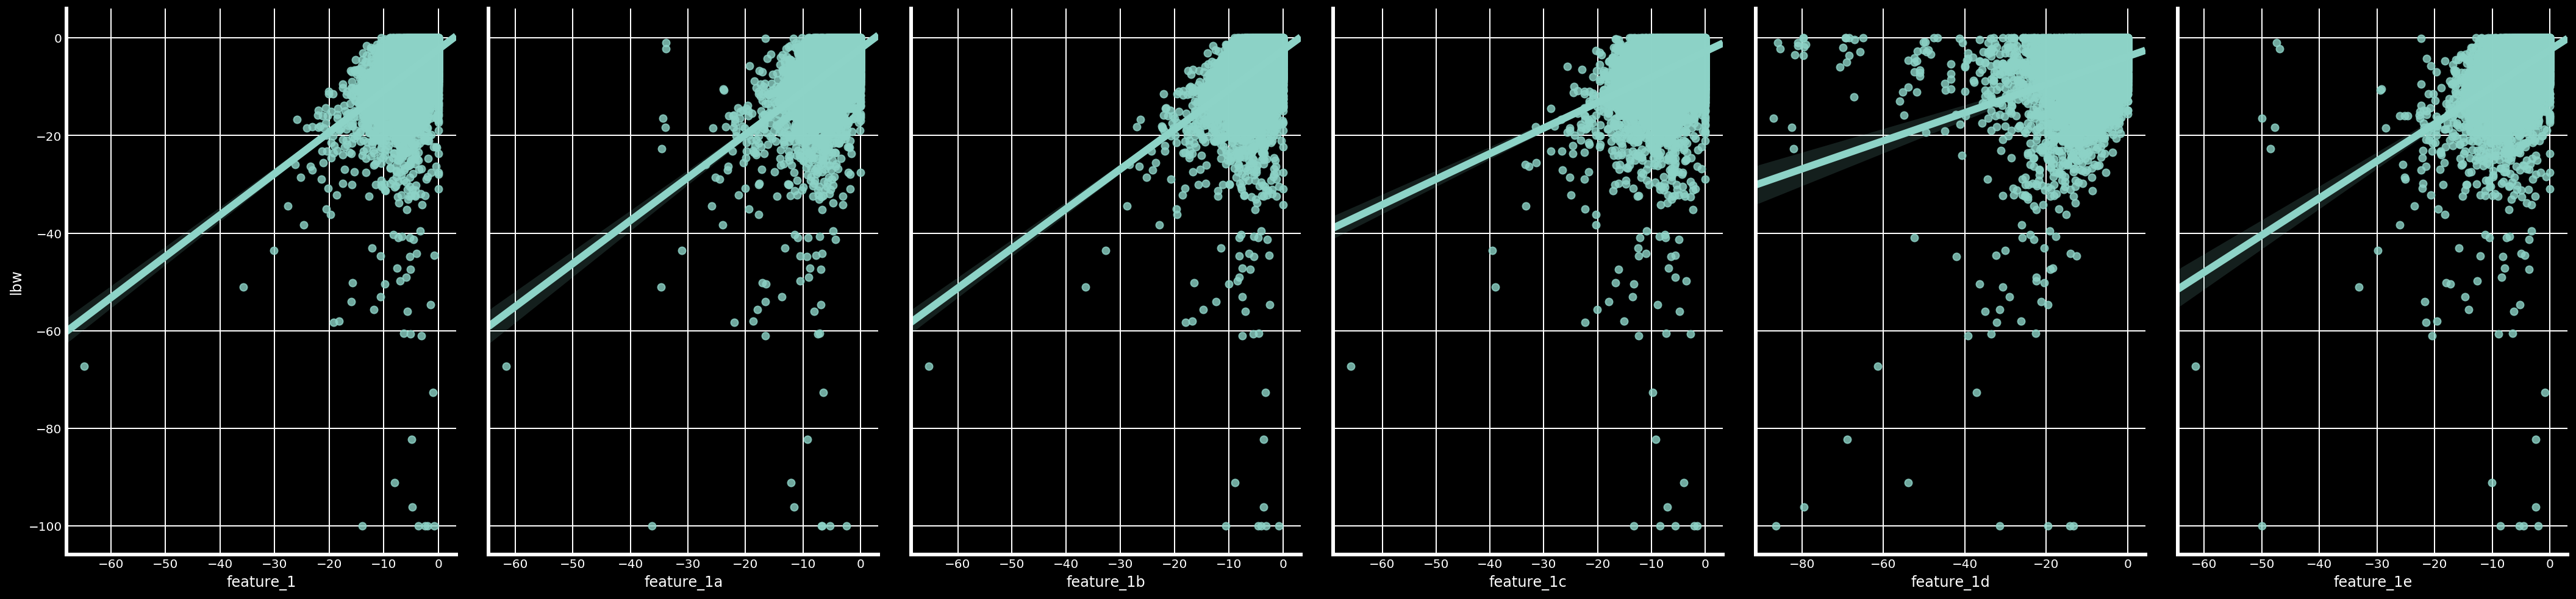

In [123]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

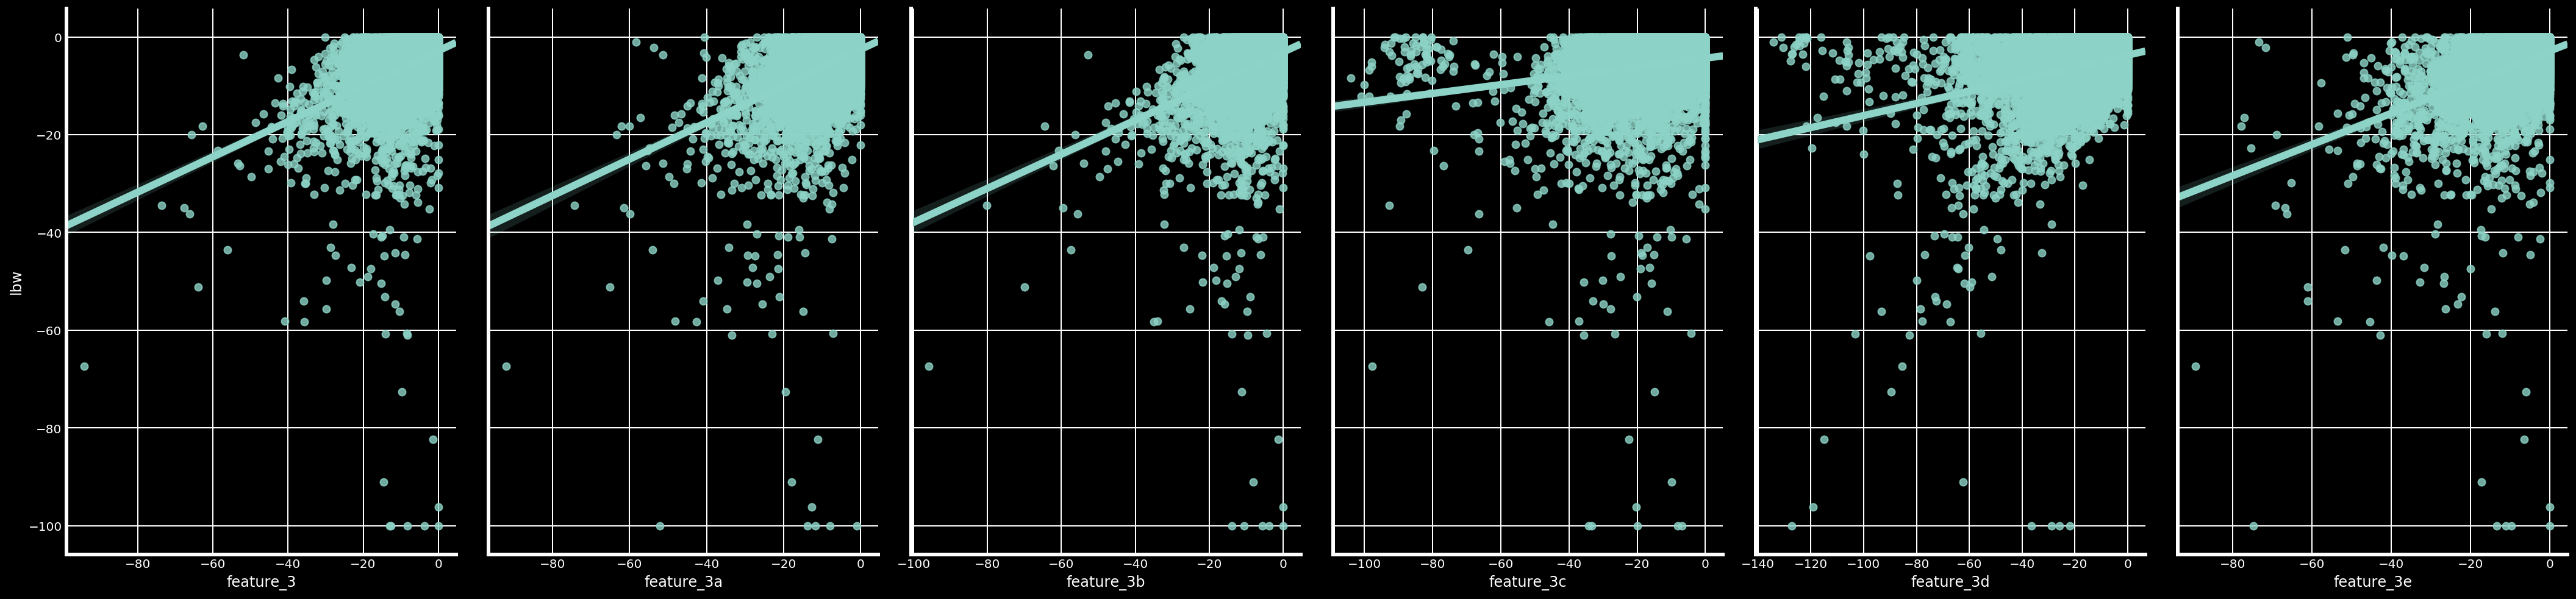

In [124]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

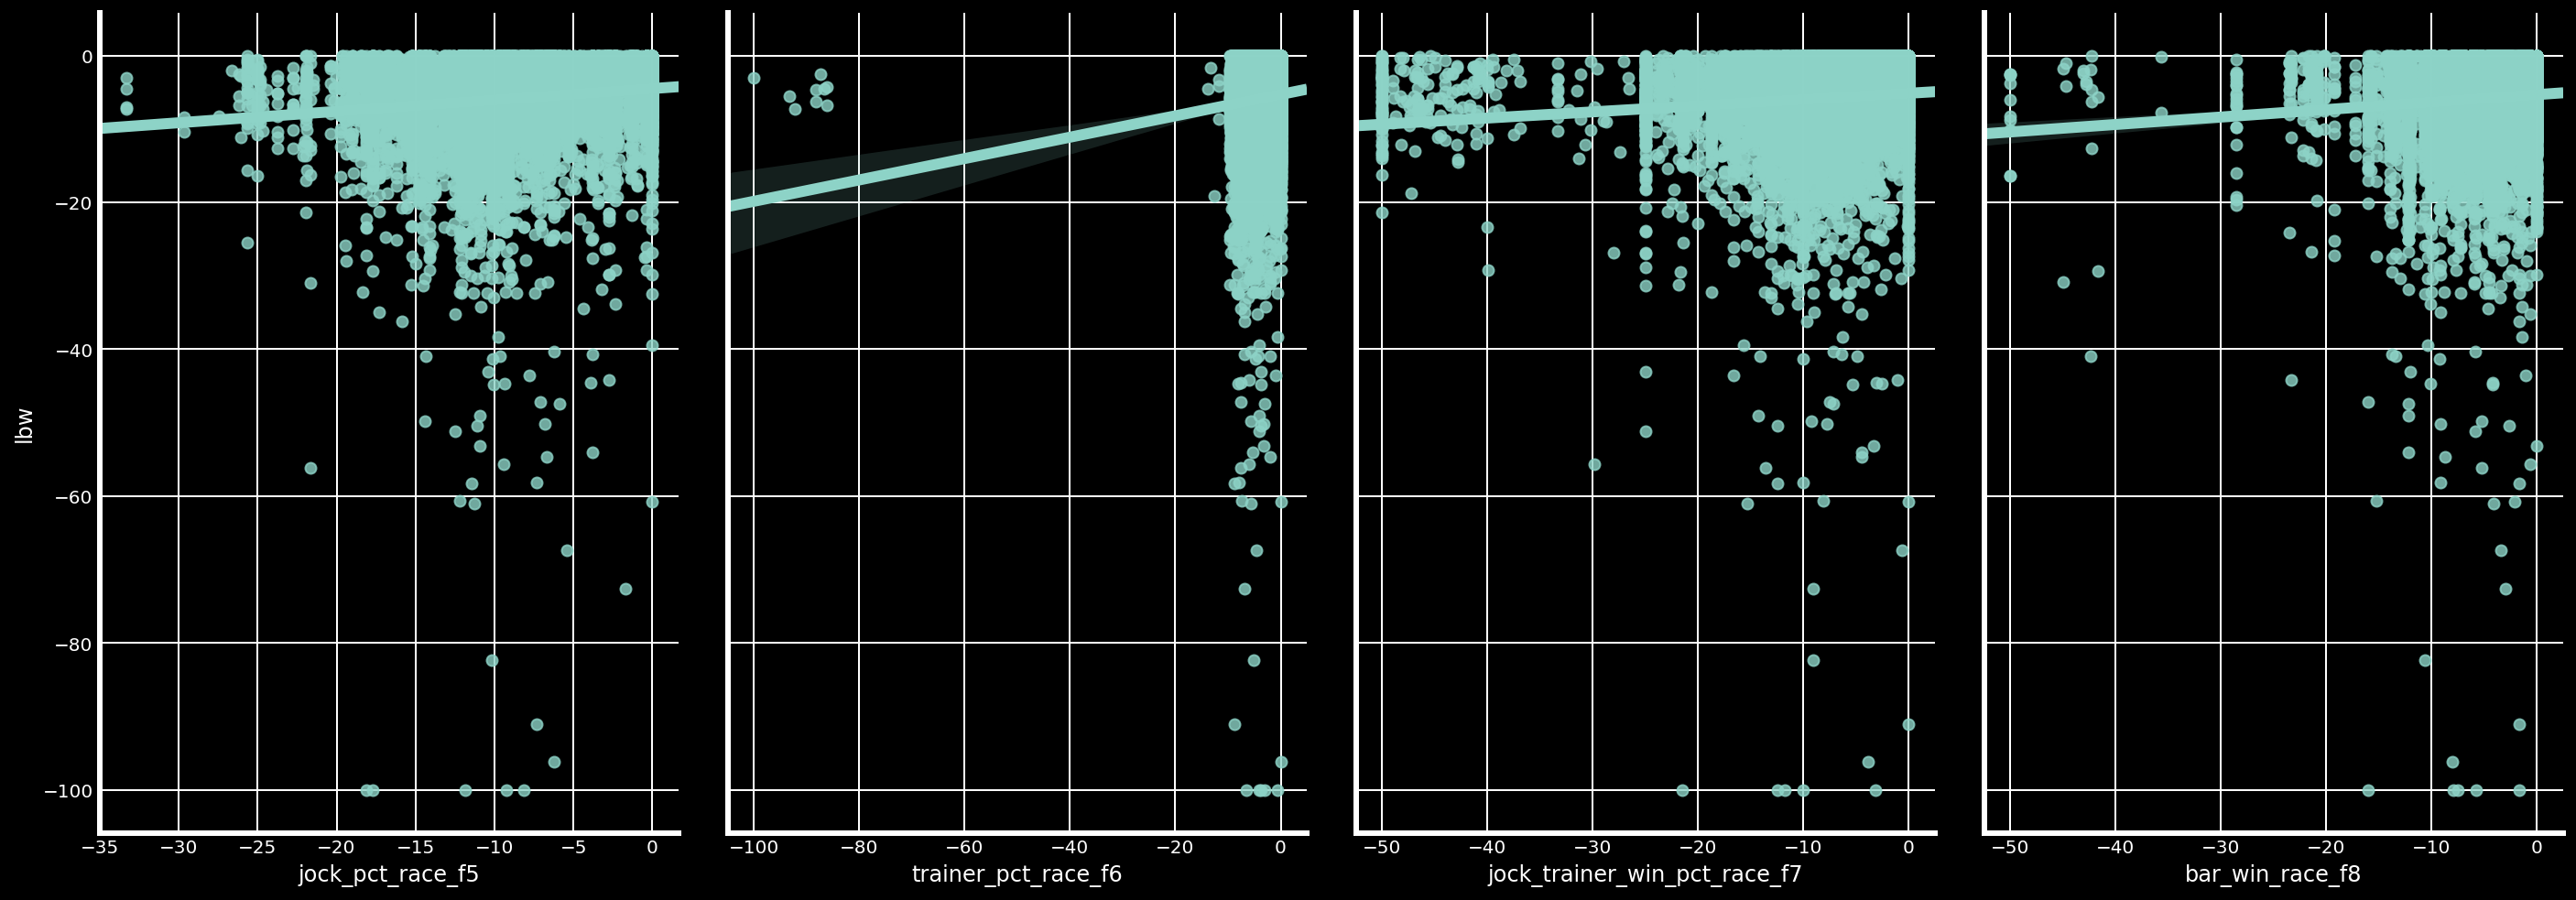

In [125]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7',
                        'bar_win_race_f8'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

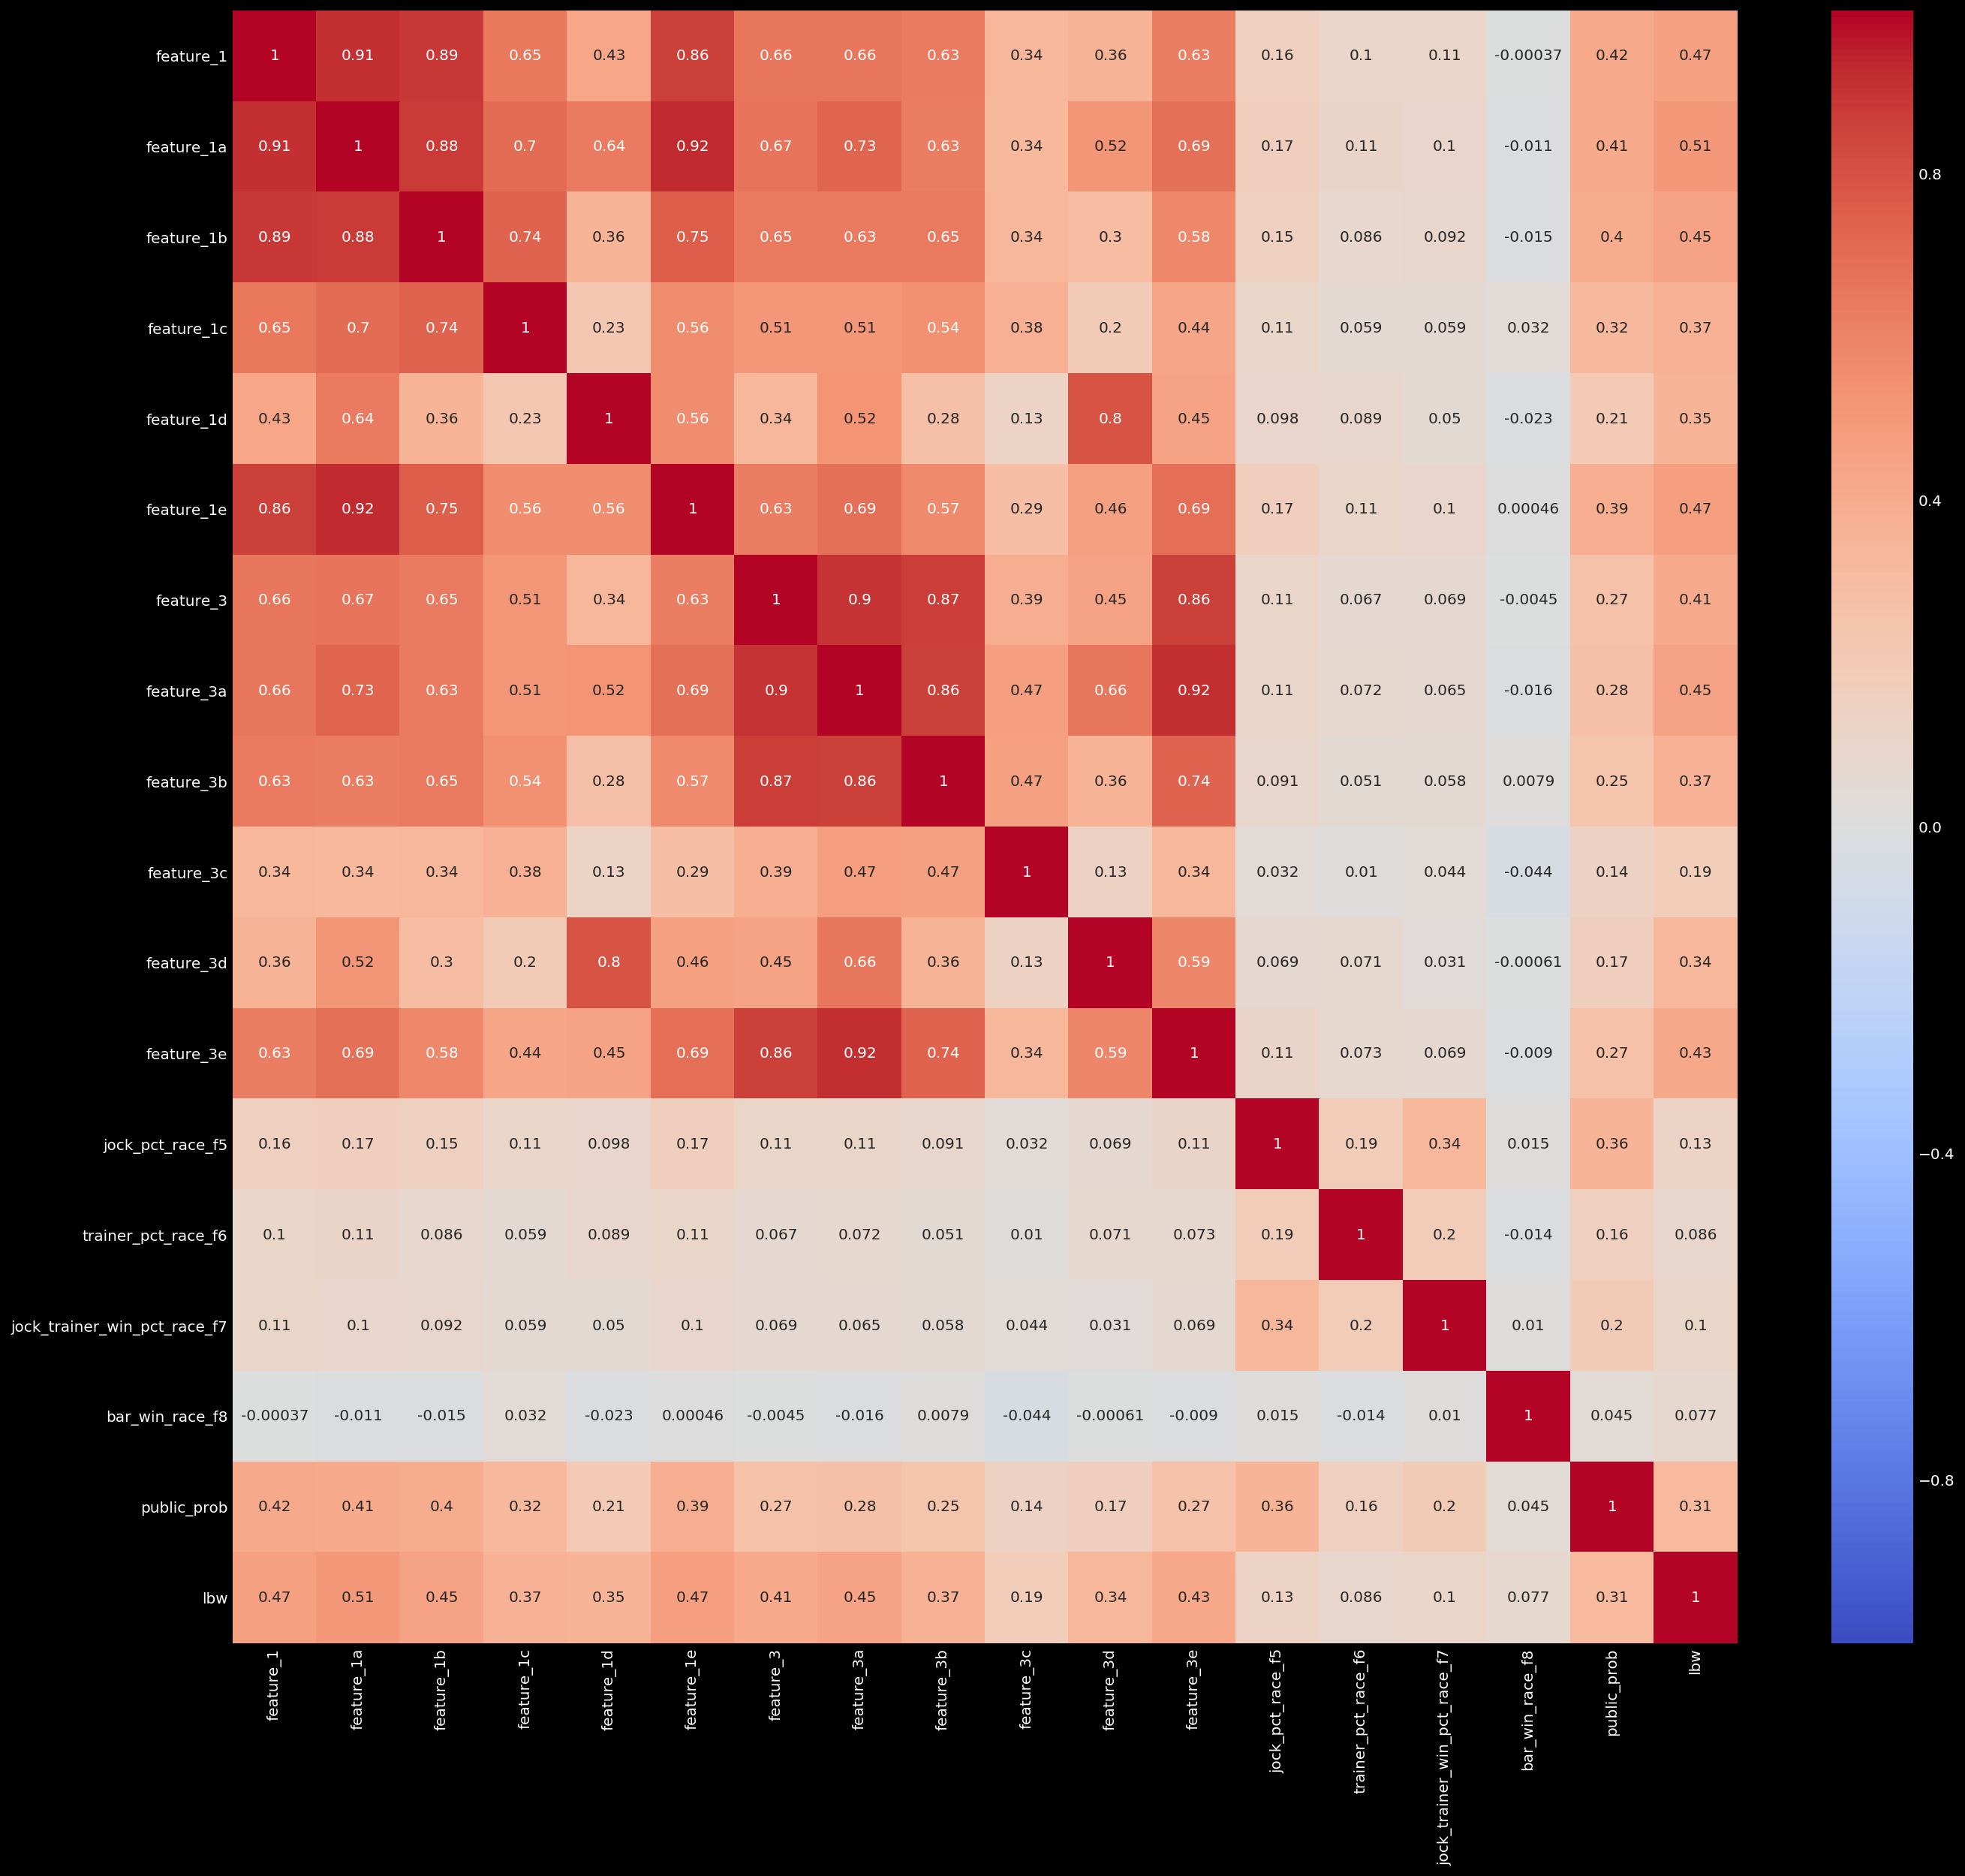

In [126]:
# Multicollinearity check. (Dropping Feature 2-2e)
# create a Python list of feature names
X = df[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
        'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
        'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8', 
        'public_prob', 'lbw'
       ]]

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 20))
plt.fontsize = 20
sns.heatmap(X.corr(), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)

### OLS Model output

#### OLS using all features

In [127]:
# using all features 1-8:
X = df[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
        'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
        'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8', 
        'public_prob'
       ]] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -1.4912140032932966
Coefficients: 
 [ 0.03425686  0.15324628  0.15135479  0.08358363  0.06386857  0.10400528
  0.03116555  0.01816133 -0.00259595 -0.00263005  0.02020801  0.06644934
 -0.0003708   0.01902993  0.02727369  0.09871297  0.0638668 ]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     254.6
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:36   Log-Likelihood:                -31311.
No. Observations:               10233   AIC:                         6.266e+04
Df Residuals:                   10215   BIC:                         6.279e+04
Df Model:                          17                                         
Covariance Type:            nonr

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [128]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [129]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.2


In [130]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.298


#### OLS using all features (excluding public_prob & feature 2-2e)

In [131]:
# using all features 1-8:
X = df[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
        'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
        'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8',
        
       ]] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 0.07180468569719345
Coefficients: 
 [ 0.07190777  0.11476629  0.18751311  0.09898789  0.06707182  0.13892371
  0.03384781  0.0121549  -0.00710318 -0.00141769  0.02184374  0.06619023
  0.03569542  0.03159983  0.03279345  0.10495907]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     258.1
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:00:36   Log-Likelihood:                -31381.
No. Observations:               10233   AIC:                         6.280e+04
Df Residuals:                   10216   BIC:                         6.292e+04
Df Model:                          16                                         
Covariance Type:            nonrobust       

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [132]:
# make prediction on the entire data set from X ('public_prob')
X = X.drop(['const'], axis=1)
y_pred_total = regr.predict(X)

In [133]:
# Computing the RMSE (the standard deviation of 
# the unexplained variance)for 'public_prob' predictions
print("RMSE: {:.1f}".format(np.sqrt(
    metrics.mean_squared_error(y, y_pred_total))))

RMSE: 5.2


In [134]:
# Computing the R^2 (the standard deviation of the unexplained variance)for 'public_prob' predictions
print("R2: {:.3f}".format(regr.score(X, y)))

R2: 0.288


In [135]:
# number of days since last run (used for dropping wagers with no history - Maidens etc)
df['prev_race_date'] = df.groupby('horse_name')['date'].shift(1)
df['prev_race_date'] = pd.to_datetime(df.prev_race_date)
df = df.assign(days_since_prev_race = ((df['prev_race_date'] - df['date'] ) )) # days
df['days_since_prev_race']=df['days_since_prev_race'].dt.days
df['days_since_prev_race'].fillna(0,inplace=True)

In [136]:
# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('index', axis=1)

In [137]:
# save engineered features dataset back to folder

df.to_csv('./datasets/stc_data_engineered.csv')

In [142]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df.loc[(df['date'] == '2019-07-21') & (df['race'] == 9)]


,date,race,class,distance,surface,horse_name,horse_rating,horse_weight,hcp_weight,c_wt,bar,jockey,trainer,lbw,l100m_time_2,l100m_distance_2,l100m_km_hr_2,peak_km_hr_2,avg_km_hr_2,distance_traveled_2,win_div_3,indexing,surf_numb,indexing_surf_dist,indexing_surf_dist_bar,indexing_date_race,indexing_date_horse,indexing_surf_dist_10,indexing_surf_dist_horse,binned_win_div_3,public_prob,total_count,win_count,total_wager,return_wager,loss_rebate,profit_loss,binned_prob_win_div_3,standard_speed_1,lengths_vs_standard_1,horse_race_count,horse_mean_vs_standard,horse_stdev,horse_min_vs_standard,horse_bot_qtr_vs_standard,horse_median_vs_standard,horse_top_qtr_vs_standard,horse_max_vs_standard,feature_1,feature_1a,feature_1b,feature_1c,feature_1d,feature_1e,standard_speed_3,lengths_vs_standard_3,horse_race_count_3,horse_mean_vs_standard_3,horse_stdev_3,horse_min_vs_standard_3,horse_bot_qtr_vs_standard_3,horse_median_vs_standard_3,horse_top_qtr_vs_standard_3,horse_max_vs_standard_3,feature_3,feature_3a,feature_3b,feature_3c,feature_3d,feature_3e,jock_pct,max_jock_pct_race,jock_pct_race_f5,trainer_pct,max_trainer_pct_race,trainer_pct_race_f6,jock_trainer_combo,jock_trainer_win_pct,max_jock_trainer_pct_race,jock_trainer_win_pct_race_f7,bar_win_mean,bar_win_max_race,bar_win_race_f8,prev_race_date,days_since_prev_race
10203,2019-07-21,9,G1,1800,T,SUN MARSHAL,82,517,57.0,57.0,12,J AZZOPARDI,DL FREEDMAN,0.0,6.37,101.0,57.0,68.5,60.1,1826.0,120,10203,1.0,1800.0,21600.0,2019-07-21 00:00:009,2019-07-21 00:00:00SUN MARSHAL,1800.0,1800.0SUN MARSHAL,$21+; Prob. <25%,4.166667,1,1,5,120,0.0,115.0,$51+; <10%,59.891374,1.460383,6.0,5.774945,3.045699,1.460383,4.481562,5.368033,7.281562,10.347743,-3.102874,-1.237229,-2.010654,-5.944473,0.000000,-2.621176,58.222204,2.294569,6.0,6.418200,3.461415,2.294569,3.503307,7.011885,8.315807,11.106635,-5.501133,-4.076024,-7.995131,-13.028987,0.000000,-4.226307,11.235955,18.108652,-6.872697,12.571429,13.776722,-1.205294,DL FREEDMANJ AZZOPARDI,10.526316,13.076923,-2.550607,6.250000,19.230769,-12.980769,2019-06-21,-30.0
10204,2019-07-21,9,G1,1800,T,MR CLINT,85,519,57.0,57.0,15,B PINHEIRO,DL FREEDMAN,-0.3,6.17,101.0,58.9,65.6,59.9,1820.0,237,10204,1.0,1800.0,27000.0,2019-07-21 00:00:009,2019-07-21 00:00:00MR CLINT,1800.0,1800.0MR CLINT,$21+; Prob. <25%,2.109705,1,0,5,0,0.5,-4.5,$51+; <10%,59.891374,0.060383,11.0,5.962339,3.267607,0.060383,4.302738,5.660383,8.152738,11.318033,-2.810524,-1.049835,-1.139478,-4.974183,-1.400000,-2.800000,58.222204,8.244569,11.0,7.787899,5.345584,1.236885,4.618341,6.285622,10.214500,19.436885,-6.227396,-2.706325,-6.096438,-4.698736,-1.057683,-3.111273,0.000000,18.108652,-18.108652,12.571429,13.776722,-1.205294,DL FREEDMANB PINHEIRO,0.000000,13.076923,-13.076923,0.000000,19.230769,-19.230769,2019-06-30,-21.0
10205,2019-07-21,9,G1,1800,T,KING LOUIS,85,544,57.0,57.0,14,W PIKE,R LE GRANGE,-1.6,6.43,101.0,56.5,65.6,60.0,1825.0,54,10205,1.0,1800.0,25200.0,2019-07-21 00:00:009,2019-07-21 00:00:00KING LOUIS,1800.0,1800.0KING LOUIS,$21+; Prob. <25%,9.259259,1,0,5,0,0.5,-4.5,$51+; <10%,59.891374,0.760383,11.0,6.259180,3.485750,0.760383,4.177718,5.702738,9.212863,11.392216,-2.768169,-0.752994,-0.079354,-4.900000,-0.700000,-2.925021,58.222204,0.194569,11.0,8.504280,8.319995,-5.763115,1.974951,12.513018,13.740095,22.306635,0.000000,-1.989944,-2.570842,-1.828987,-8.057683,-5.754662,0.000000,18.108652,-18.108652,11.799410,13.776722,-1.977312,R LE GRANGEW PIKE,0.000000,13.076923,-13.076923,10.000000,19.230769,-9.230769,2019-06-30,-21.0
10206,2019-07-21,9,G1,1800,T,WHAT'S NEW,88,426,55.5,55.5,13,B THOMPSON,C BROWN,-2.6,6.49,100.0,55.4,66.0,59.8,1823.0,25,10206,1.0,1800.0,23400.0,2019-07-21 00:00:009,2019-07-21 00:00:00WHAT'S NEW,1800.0,1800.0WHAT'S NEW,$21+; Prob. <25%,20.000000,1,0,5,0,0.5,-4.5,$17-25; 20-30%,59.891374,-0.639617,11.0,4.893493,4.084050,-0.852257,1.839208,5.718033,7.126300,12.447743,-2.752874,-2.118681,-2.165916,-3.844473,-2.312641,-5.263530,58.222204,-4.355431,11.0,8.284316,6.280886,-4.355431,4.

In [139]:
Stop.Stop()

NameError: name 'Stop' is not defined

# Testing Area:

In [ ]:
# Daily bias adjustment:
# last start fav.
# rating (highest in the past year vs current race avg)
# inside bar & leading finish
# track variance for weather
# 

In [ ]:
df

In [ ]:
X = df[['days_since_prev_race']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

In [ ]:
# Chart of 'horse_speed_race_f1' to 'lbw' 

plt.style.use('dark_background')
sns.lmplot(x='days_since_prev_race', y='lbw', data=df)

# Add title and axis names
plt.title('Days since last race: Raw Data Plot Performance')
plt.xlabel('Feature Forecast of Lengths Behind Winner')
plt.ylabel('Actual Performance of Lengths Behind Winner')

plt.xlim(0, -200)  
plt.ylim(-20, 0)  

plt.show()

# Testing Unused:

### Engineered Feature 1f:  Standard Deviation (horse_stdev)

In [ ]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
df['horse_stdev'].fillna(0,inplace=True)
temp = df.groupby(['indexing_date_race']).horse_stdev.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1f'}, inplace=True)

# new column in df 
df = df.assign(feature_1f = ((df['horse_stdev'] - df['temp_1f'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('temp_1f', axis=1)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
X = df[['feature_1f']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


### Engineered Feature 1g:  Race Count (horse_race_count)

In [ ]:
# Mean speed then Groupby date & surf, and calc max for each race as save in temp df:
temp = df.groupby(['indexing_date_race']).horse_race_count.agg(['max'])

# merge max back into df groupby indexing_date_race:
df = pd.merge(df, temp, on='indexing_date_race')
df.rename(columns={'max': 'temp_1g'}, inplace=True)

# new column in df 
df = df.assign(feature_1g = ((df['horse_race_count'] - df['temp_1g'] ) )) 

# return df to original order:
df = df.sort_values(by=['indexing'], ascending =True)
df = df.reset_index()
df = df.drop('temp_1g', axis=1)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
X = df[['feature_1g']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)


In [ ]:
# replace outliers:
df['horse_speed_race_f1'] = np.where(df['horse_speed_race_f1'] < -50, -50,df['horse_speed_race_f1'])
df['horse_speed_race_f2'] = np.where(df['horse_speed_race_f2'] < -50, -50,df['horse_speed_race_f2'])
df['horse_speed_race_f3'] = np.where(df['horse_speed_race_f3'] < -120, -120,df['horse_speed_race_f3'])
df['horse_speed_race_f4'] = np.where(df['horse_speed_race_f4'] < -80, -80,df['horse_speed_race_f4'])
df['jock_pct_race_f5'] = np.where(df['jock_pct_race_f5'] < -30, -30,df['jock_pct_race_f5'])
df['trainer_pct_race_f6'] = np.where(df['trainer_pct_race_f6'] < -10, -10,df['trainer_pct_race_f6'])
df['jock_trainer_win_pct_race_f7'] = np.where(df['jock_trainer_win_pct_race_f7'] < -50, -50,df['jock_trainer_win_pct_race_f7'])
df['bar_win_race_f8'] = np.where(df['bar_win_race_f8'] < -40, -40,df['bar_win_race_f8'])

### Plot after Outliers:

KeyError: 'horse_speed_race_f1'

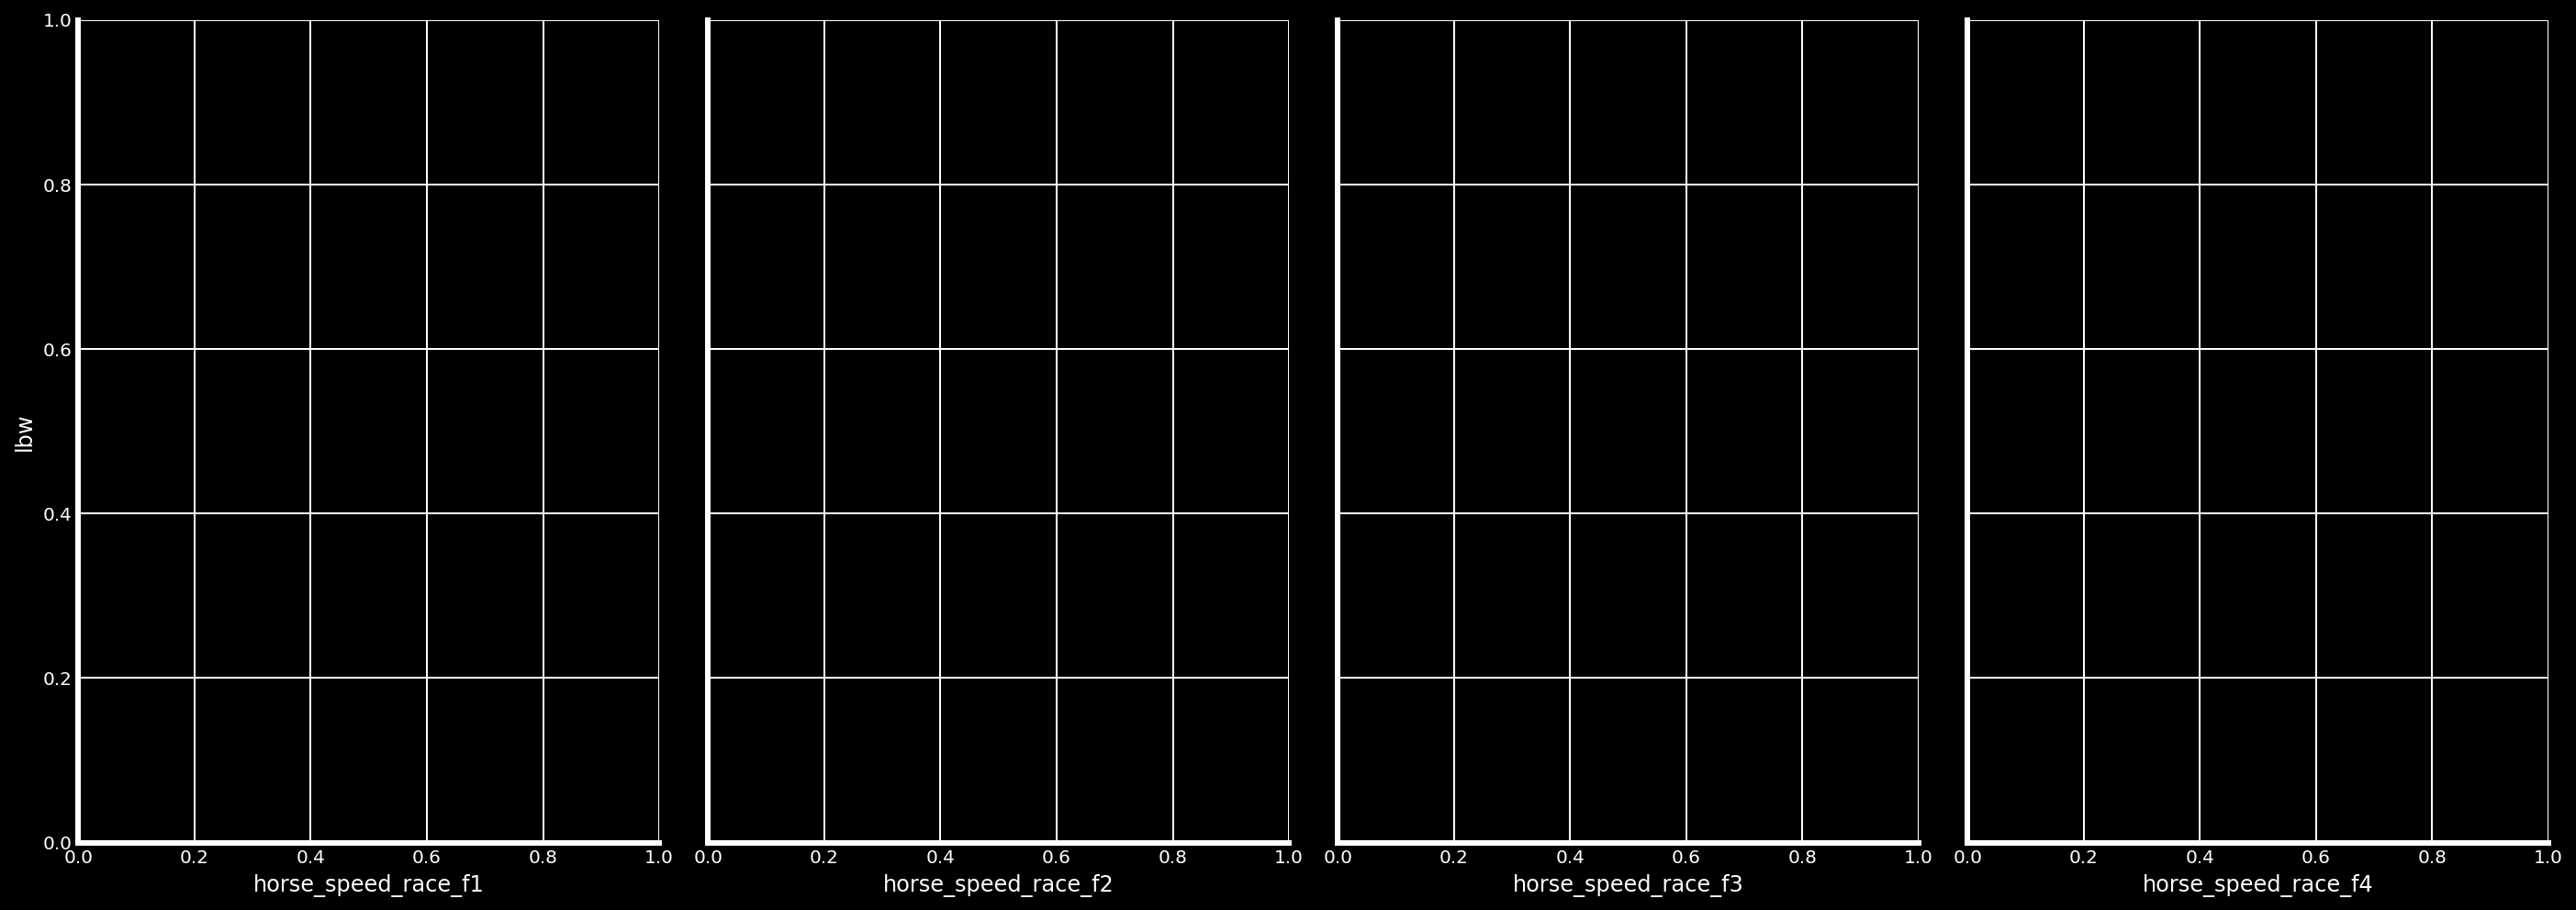

In [143]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['horse_speed_race_f1', 'horse_speed_race_f2', 'horse_speed_race_f3',
                         'horse_speed_race_f4',],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

In [ ]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['jock_pct_race_f5', 'trainer_pct_race_f6', 
                         'jock_trainer_win_pct_race_f7', 'bar_win_race_f8'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')